# Imports

In [14]:
pip install Faker


In [48]:
from tensorflow.keras.layers import Bidirectional, Concatenate, Permute, Dot, Input, LSTM, Multiply
from tensorflow.keras.layers import RepeatVector, Dense, Activation, Lambda
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model, Model
import tensorflow.keras.backend as K
import tensorflow as tf
import numpy as np
from faker import Faker
import random
from tqdm import tqdm     #
from babel.dates import format_date
from test_utils import *
import matplotlib.pyplot as plt
%matplotlib inline




## Functions for creating dataset

In [107]:
fake = Faker()
Faker.seed(54321)
random.seed(54321)

# Define format of the dataset we would like to generate
FORMATS = ['short',
           'medium',
           'long',
           'full',
           'full',
           'full',
           'full',
           'full',
           'full',
           'full',
           'full',
           'full',
           'full',
           'd MMM YYY',
           'd MMMM YYY',
           'dd MMM YYY',
           'd MMM, YYY',
           'd MMMM, YYY',
           'dd, MMM YYY',
           'd MM YY',
           'd MMMM YYY',
           'MMMM d YYY',
           'MMMM d, YYY',
           'dd.MM.YY']

LOCALES = ["en_US"]

def load_date():
  dt = fake.date_object()
  try:
    human_readable = format_date(dt, format = random.choice(FORMATS), locale='en_US')
    human_readable = human_readable.lower()
    human_readable = human_readable.replace(',','')
    machine_readable = dt.isoformat()
  except AttributeError as e:
    return None, None, None
  return human_readable, machine_readable, dt

def load_dataset(m):
  human_vocab = set()
  machine_vocab = set()
  dataset = []
  Tx = 30

  for i in tqdm(range(m)):
    h, m, _ = load_date()
    if h is not None:
      dataset.append((h,m))
      human_vocab.update(tuple(h))
      machine_vocab.update(tuple(m))
  human = dict(zip(sorted(human_vocab)+['<unk>', '<pad>'], list(range(len(human_vocab) + 2))))
  inv_machine = dict(enumerate(sorted(machine_vocab)))
  machine = {v:k for k, v in inv_machine.items()}
  return dataset, human, machine, inv_machine


def string_to_int(string, length, vocab):
  string = string.lower()
  string = string.replace(",", "")

  if len(string)> length:
    string = string[:length]
  rep = list(map(lambda x: vocab.get(x, '<unk>'), string))
  if len(string)< length:
    rep += [vocab['<pad>']] * (length - len(string))
  return rep


def int_to_string( ints, inv_vocab):
  l = [inv_vocab[i] for i in ints]
  return l


def preprocess_data(dataset, human_vocab, machine_vocab, Tx, Ty):
  X, Y = zip(*dataset)
  X = np.array([string_to_int(i, Tx, human_vocab) for i in X])
  Y = [string_to_int(t, Ty, machine_vocab) for t in Y]
  Xoh = np.array(list(map(lambda x: to_categorical(x, num_classes=len(human_vocab)), X)))
  Yoh = np.array(list(map(lambda x: to_categorical(x, num_classes=len(machine_vocab)), Y)))

  return X, np.array(Y), Xoh, Yoh

def softmax(x, axis=1):
    """Softmax activation function.
    # Arguments
        x : Tensor.
        axis: Integer, axis along which the softmax normalization is applied.
    # Returns
        Tensor, output of softmax transformation.
    # Raises
        ValueError: In case `dim(x) == 1`.
    """
    ndim = K.ndim(x)
    if ndim == 2:
        return K.softmax(x)
    elif ndim > 2:
        e = K.exp(x - K.max(x, axis=axis, keepdims=True))
        s = K.sum(e, axis=axis, keepdims=True)
        return e / s
    else:
        raise ValueError('Cannot apply softmax to a tensor that is 1D')



## Dataset

In [50]:
m = 10000
dataset, human_vocab, machine_vocab, inv_machine_vocab = load_dataset(m)

100%|██████████| 10000/10000 [00:00<00:00, 23479.59it/s]


In [51]:
dataset[:10]

[('03 apr 2003', '2003-04-03'),
 ('march 30 2023', '2023-03-30'),
 ('sunday september 22 1974', '1974-09-22'),
 ('saturday august 23 1986', '1986-08-23'),
 ('14 august 1981', '1981-08-14'),
 ('15 aug 2007', '2007-08-15'),
 ('saturday december 17 2005', '2005-12-17'),
 ('tuesday september 17 1996', '1996-09-17'),
 ('friday december 4 1981', '1981-12-04'),
 ('6 jan 1992', '1992-01-06')]

In [52]:
print(len(machine_vocab))
print(len(human_vocab))

11
37


In [53]:
Tx =30
Ty = 10

X,Y, Xoh, Yoh = preprocess_data(dataset, human_vocab, machine_vocab, Tx, Ty)

In [54]:
print("X.shape:", X.shape)
print("Y.shape:", Y.shape)
print("Xoh.shape:", Xoh.shape)
print("Yoh.shape:", Yoh.shape)

X.shape: (10000, 30)
Y.shape: (10000, 10)
Xoh.shape: (10000, 30, 37)
Yoh.shape: (10000, 10, 11)


## one_step_attention

In [55]:
repeator = RepeatVector(Tx)
concatenator = Concatenate(axis=-1)
densor1 = Dense(10, activation = "tanh")
densor2 = Dense(1, activation = "relu")
activator = Activation(softmax, name='attention_weights')
dotor = Dot(axes = 1)

In [56]:
def one_step_attention(a, s_prev):
# Use repeator to repeat s_prev to be of shape (m, Tx, n_s) so that you can concatenate it with all hidden states "a"
  s_prev = repeator(s_prev)
#Use concatenator to concatenate a and s_prev on the last axi
  concat = concatenator([a, s_prev])
# Use densor1 to propagate concat through a small fully-connected neural network to compute the "intermediate energies" variable e.

  e = densor1(concat)
# Use densor2 to propagate e through a small fully-connected neural network to compute the "energies" variable energies.

  energies = densor2(e)
# Use "activator" on "energies" to compute the attention weights "alphas"

  alphas = activator(energies)
# Use dotor together with "alphas" and "a", in this order, to compute the context vector to be given to the next (post-attention) LSTM-cell (≈ 1 line)

  context = dotor([alphas, a])

  return context

## Model

In [95]:
n_a = 32 #number of units for the pre_attention , bi-directional LSTM's hidden state "a"
n_s = 64 #number of units for the post-attention LSTM's hidden state "s"
post_activation_LSTM_cell = LSTM(n_s, return_state= True)
output_layer = Dense(len(machine_vocab),  activation = softmax)

In [96]:
def modelf(Tx, Ty, n_a, n_s, human_vocab_size, machine_vocab_size):
    # Define the inputs of your model with a shape (Tx, human_vocab_size)
  X =Input(shape=(Tx, human_vocab_size))
    # Define s0 (initial hidden state) and c0 (initial cell state)
  s0 = Input(shape=(n_s,), name= 's0')
  c0 = Input(shape= (n_s,), name= 'c0')

  s = s0
  c = c0
  # initilize the empty list of outputs
  outputs = []
  # Define your pre attention Bi-LSTM

  a = Bidirectional(LSTM(n_a, return_sequences=True))(X)

  for t in range(Ty):
    context = one_step_attention(a,s)

    _, s, c = post_activation_LSTM_cell(context, initial_state = [s,c])

    out = output_layer(s)
    outputs.append(out)
    model = Model( inputs=[X,s0,c0], outputs = outputs)

  return model


10

In [97]:
model = modelf(Tx, Ty, n_a, n_s, len(human_vocab), len(machine_vocab))

In [98]:
model.summary()

Model: "model_45"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_21 (InputLayer)       [(None, 30, 37)]             0         []                            
                                                                                                  
 s0 (InputLayer)             [(None, 64)]                 0         []                            
                                                                                                  
 bidirectional_20 (Bidirect  (None, 30, 64)               17920     ['input_21[0][0]']            
 ional)                                                                                           
                                                                                                  
 repeat_vector_3 (RepeatVec  (None, 30, 64)               0         ['s0[0][0]',           

In [99]:
opt = Adam( learning_rate = 0.005, beta_1 = 0.9, beta_2 = 0.999)
model.compile(loss = "categorical_crossentropy", optimizer = opt, metrics = ["accuracy"])

In [100]:
s0 = np.zeros((m, n_s))
c0 = np.zeros((m, n_s))
outputs = list(Yoh.swapaxes(0,1))

In [101]:
history = model.fit([Xoh, s0, c0], outputs, epochs=20, batch_size=128)

Epoch 1/20
79/79 [==============================] - 38s 130ms/step - loss: 17.2663 - dense_11_loss: 1.2437 - dense_11_1_loss: 1.1205 - dense_11_2_loss: 1.8458 - dense_11_3_loss: 2.6457 - dense_11_4_loss: 0.8226 - dense_11_5_loss: 1.3387 - dense_11_6_loss: 2.6827 - dense_11_7_loss: 1.1578 - dense_11_8_loss: 1.7977 - dense_11_9_loss: 2.6110 - dense_11_accuracy: 0.4983 - dense_11_1_accuracy: 0.6394 - dense_11_2_accuracy: 0.2766 - dense_11_3_accuracy: 0.1015 - dense_11_4_accuracy: 0.9336 - dense_11_5_accuracy: 0.3156 - dense_11_6_accuracy: 0.0344 - dense_11_7_accuracy: 0.8148 - dense_11_8_accuracy: 0.2306 - dense_11_9_accuracy: 0.1087
Epoch 2/20
79/79 [==============================] - 10s 131ms/step - loss: 8.7106 - dense_11_loss: 0.1966 - dense_11_1_loss: 0.1400 - dense_11_2_loss: 1.0806 - dense_11_3_loss: 2.0987 - dense_11_4_loss: 0.0156 - dense_11_5_loss: 0.2371 - dense_11_6_loss: 1.7259 - dense_11_7_loss: 0.0145 - dense_11_8_loss: 1.1364 - dense_11_9_loss: 2.0653 - dense_11_accuracy: 

In [103]:
def plot_attention_map(modelx, input_vocabulary, inv_output_vocabulary, text, n_s = 128, num = 7):
    """
    Plot the attention map.

    """
    attention_map = np.zeros((10, 30))
    layer = modelx.get_layer('attention_weights')

    Ty, Tx = attention_map.shape

    human_vocab_size = 37


    X = modelx.inputs[0]
    s0 = modelx.inputs[1]
    c0 = modelx.inputs[2]
    s = s0
    c = s0

    a = modelx.layers[2](X)
    outputs = []

    for t in range(Ty):
        s_prev = s
        s_prev = modelx.layers[3](s_prev)
        concat = modelx.layers[4]([a, s_prev])
        e = modelx.layers[5](concat)
        energies = modelx.layers[6](e)
        alphas = modelx.layers[7](energies)
        context = modelx.layers[8]([alphas, a])
        # Don't forget to pass: initial_state = [hidden state, cell state] (≈ 1 line)
        s, _, c = modelx.layers[10](context, initial_state = [s, c])
        outputs.append(energies)

    f = Model(inputs=[X, s0, c0], outputs = outputs)


    s0 = np.zeros((1, n_s))
    c0 = np.zeros((1, n_s))
    encoded = np.array(string_to_int(text, Tx, input_vocabulary)).reshape((1, 30))
    encoded = np.array(list(map(lambda x: to_categorical(x, num_classes=len(input_vocabulary)), encoded)))


    r = f([encoded, s0, c0])

    for t in range(Ty):
        for t_prime in range(Tx):
            attention_map[t][t_prime] = r[t][0, t_prime]

    # Normalize attention map
    row_max = attention_map.max(axis=1)
    attention_map = attention_map / row_max[:, None]

    prediction = modelx.predict([encoded, s0, c0])

    predicted_text = []
    for i in range(len(prediction)):
        predicted_text.append(int(np.argmax(prediction[i], axis=1)))

    predicted_text = list(predicted_text)
    predicted_text = int_to_string(predicted_text, inv_output_vocabulary)
    text_ = list(text)

    # get the lengths of the string
    input_length = len(text)
    output_length = Ty

    # Plot the attention_map
    plt.clf()
    f = plt.figure(figsize=(8, 8.5))
    ax = f.add_subplot(1, 1, 1)

    # add image
    i = ax.imshow(attention_map, interpolation='nearest', cmap='Blues')

    # add colorbar
    cbaxes = f.add_axes([0.2, 0, 0.6, 0.03])
    cbar = f.colorbar(i, cax=cbaxes, orientation='horizontal')
    cbar.ax.set_xlabel('Alpha value (Probability output of the "softmax")', labelpad=2)

    # add labels
    ax.set_yticks(range(output_length))
    ax.set_yticklabels(predicted_text[:output_length])

    ax.set_xticks(range(input_length))
    ax.set_xticklabels(text_[:input_length], rotation=45)

    ax.set_xlabel('Input Sequence')
    ax.set_ylabel('Output Sequence')

    # add grid and legend
    ax.grid()

    #f.show()

    return attention_map

In [102]:
EXAMPLES = ['3 May 1979', '5 April 09', '21th of August 2016', 'Tue 10 Jul 2007', 'Saturday May 9 2018', 'March 3 2001', 'March 3rd 2001', '1 March 2001']
s00 = np.zeros((1, n_s))
c00 = np.zeros((1, n_s))
for example in EXAMPLES:
    source = string_to_int(example, Tx, human_vocab)
    #print(source)
    source = np.array(list(map(lambda x: to_categorical(x, num_classes=len(human_vocab)), source))).swapaxes(0,1)
    source = np.swapaxes(source, 0, 1)
    source = np.expand_dims(source, axis=0)
    prediction = model.predict([source, s00, c00])
    prediction = np.argmax(prediction, axis = -1)
    output = [inv_machine_vocab[int(i)] for i in prediction]
    print("source:", example)
    print("output:", ''.join(output),"\n")

1/1 [==============================] - 6s 6s/step
source: 3 May 1979
output: 1979-05-03 

1/1 [==============================] - 0s 28ms/step
source: 5 April 09
output: 2009-04-05 

1/1 [==============================] - 0s 29ms/step
source: 21th of August 2016
output: 2016-08-21 

1/1 [==============================] - 0s 38ms/step
source: Tue 10 Jul 2007
output: 2007-07-10 

1/1 [==============================] - 0s 29ms/step
source: Saturday May 9 2018
output: 2018-05-09 

1/1 [==============================] - 0s 32ms/step
source: March 3 2001
output: 2001-03-03 

1/1 [==============================] - 0s 48ms/step
source: March 3rd 2001
output: 2001-03-03 

1/1 [==============================] - 0s 51ms/step
source: 1 March 2001
output: 2001-03-01 



1/1 [==============================] - 0s 37ms/step


<ipython-input-103-53ace7f8c4f9>:52: RuntimeWarning: invalid value encountered in divide
  attention_map = attention_map / row_max[:, None]


<Figure size 640x480 with 0 Axes>

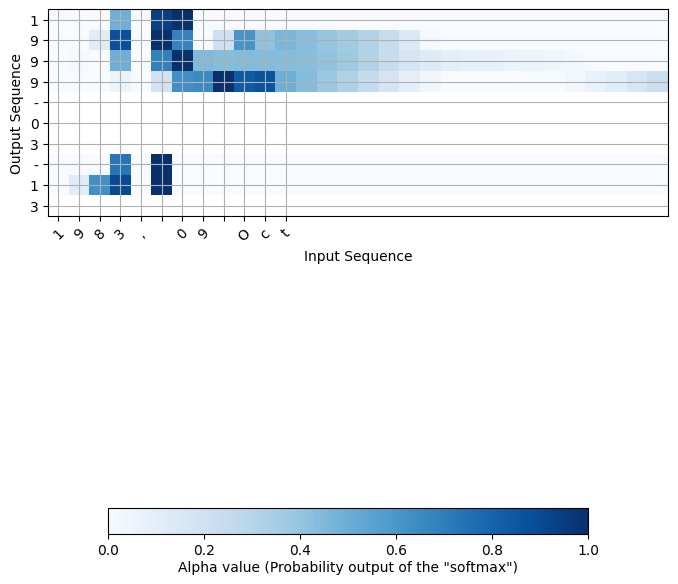

In [110]:
attention_map = plot_attention_map(model, human_vocab, inv_machine_vocab, "1983, 09 Oct", num = 7, n_s = 64);